# Case 2. Diabetic retinopathy diagnosis
Mr.Pasin Jiratthitcheep<br>
Last edited: 24.02.2019<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 0. Table of contents

1. Objectives
2. Required libraries
3. Data description and preprocessing
4. Modeling and compilation
    * Model 1 : Xception pretrained model
    * Model 2 : Xception pretrained model (freezing weight)
    * Model 3 : InceptionResNetV2 pretrained model
    * Model 4 : InceptionResNetV2 pretrained model (freezing weight)
    * Model 5 : 4 convolutional layers model
5. Training and Validation
    * Training Model 1 (Xception pretrained model)
        - Go further with Model 1 (Xception pretrained model)
    * Training Model 2 (Xception pretrained model (freezing weight))
    * Training Model 3 (InceptionResNetV2 pretrained model)
        - Go further with Model 3 (InceptionResNetV2 pretrained model)
    * Training Model 4 (InceptionResNetV2 pretrained model (freezing weight))
    * Training Model 5 (4 convolutional layers model)
6. Evaluation
    * Selcetion the best of all
    * Comparison with training by imbalance dataset
7. Results and discussion
    * Final model with test set
    * ROC Curve
    * Trying to change decisoin point
8. Conclusions

## 1. Objectives

This notebook was created for learning to use convolutional neural networks to classify medical images. The study case is about <b>Diabetic retinopathy</b> that is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease.

I hoped to learn about how to preprocess the images dataset and what are the techniques those can be implemented with image classification.

## 2. Required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, cv2, time
import pandas as pd
import pickle

import keras
from keras import backend as K
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications import InceptionResNetV2, Xception
from keras.layers import Dense, Activation
from keras.models import Model, load_model

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import accuracy_score, roc_curve
import warnings

%matplotlib inline

Using TensorFlow backend.


## 3. Data description and preprocessing

I used a dataset from https://www.kaggle.com/sakarilukkarinen/preprocessed-diabetic-retinopathy-trainset that it was preprocessed by basing on <b>Benjamin Graham's Competition report</b> (that Sakari shared to us).

In his report he explains that he used the following <b>preprocessing strategy</b>:
    1. Rescale the images to have the same radius (scale = 300 pixels).
    2. Subtract the local average color from the images (50% gray).
    3. Mask the image to 90% of the scale to remove the boundary effects.
    
In additional, images were devided into 2 folders (300_train and 300_test) and it also include csv files (newTrainLabels.csv and retinopathy_solution.csv) those content label data for each image in the folders. The <b>newTrainLabels.csv contains totally 35,124 records</b> and the <b>retinopathy_solution.csv contains 53,576 records</b>.

<b>Columns of newTrainLabels.csv:</b>
    * image = name of the image file (without the extension *.jpeg)
    * level = level of the retinopathy (0 = healthy, ..., 4 = severe)
    * MB = size of the image file in MegaBytes
    
<b>Columns of newTrainLabels.csv:</b>
    * image = image name
    * level = diabetic retinopathy level (0 = Healthy, ..., 4 = Severe)
    * Usage = Usage in original competition (public = for public rankings, private = for private rankings)

I defined most of variables here. I used image size <b>only 150x150 pixel because of my resource limitation</b> even I know that the performance will be better if we use larger image size (my GPU on laptop can't calculate too big image size). So, I decided to increase the number of training-set instead by using <b>6,000 records</b> from 300_train folder for training and validaton (4,500 for training and 1,500 for validation). For the batch size, I already tried larger than 16, but my resurce can't handle them, so I decided to use <b>16 for my batch size</b>. And test set has balanced class distribution with <b>total amount 10,000 records</b>.

In [2]:
# Raw images directories
raw_train_dir = "./input/300_train/"
raw_test_dir = "./input/300_test/"

SIZE = 6000 # Total number of images pooled from 300_train
SPLIT = 4500 # Number of images used for training
Test_SIZE = 10000 # Total number of image pooled from 300_test for testing set
BATCH_SIZE = 16
TRAIN_STEPS = SPLIT // BATCH_SIZE
VALID_STEPS = (SIZE - SPLIT) // BATCH_SIZE
EPOCHS = 100
N_EPOCHS = 0
IMAGE_SIZE = 150
seed = 24 # Seed for random sample the dataset

print('Training set:    ', SPLIT)
print('Validation set:  ', SIZE - SPLIT)
print('Test set:        ', Test_SIZE)
print('Batch size:      ', BATCH_SIZE)
print('Training steps:  ', TRAIN_STEPS)
print('Validation steps:', VALID_STEPS)
print('Epochs:          ', EPOCHS)
print('Image size:      ', (IMAGE_SIZE, IMAGE_SIZE, 3))

Training set:     4500
Validation set:   1500
Test set:         10000
Batch size:       16
Training steps:   281
Validation steps: 93
Epochs:           100
Image size:       (150, 150, 3)


In [3]:
# Read csv file data for training-set and validation-set
df = pd.read_csv(r"./input/newTrainLabels.csv")

# Show top 5 record of csv file
df.head()

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906


After I get dataframe from newTrainLabels.csv, I changed label <b>from 5-classes into only binary-classes</b> then I showed the number of records for each class in the dataframe.

In [4]:
# Change categorical labels into binary labels
df['level'] = 1*(df['level'] > 0)

# Show distribution of datset for each class
print("How many records for each class")
df['level'].value_counts()

How many records for each class


0    25808
1     9316
Name: level, dtype: int64

As you can see from the number of records for eah class in dataset, our dataset has <b>imbalanced class distribution</b>. 

As far as I know, some of machine learning algorithms have a bias towards classes based on number of instances. They tend to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class. By using imbalanced dataset to train model, it maybe tend to get a bias model, but I'm not sure about this case from many notebook examples those seem to doesn't care much about this. So I decided to <b>create both balanced and imbalanced set</b> to test my hypothesis. I will use them later.

In [84]:
# Sample unbalanced dataframe as normally
df_unbalance = df.sample(n = SIZE, random_state = seed)

# Show distribution of datset for each class
print("How many records for each class (imbalance data)")
df_unbalance['level'].value_counts()

How many records for each class (imbalance data)


0    4419
1    1581
Name: level, dtype: int64

This is how I create my balanced set. I group the dataframe by level column first and then sample each of them with the equal size.

In [6]:
# Group records by level feature
g = df.groupby('level')

# Sample records equal to SIZE//2 for each group for balancing the dataset
df_balance = g.apply(lambda x: x.sample(SIZE//2, random_state = seed).reset_index(drop=True))

# Show distribution of datset for each class
print("How many records for each class (after balancing)")
df_balance['level'].value_counts()

How many records for each class (after balancing)


1    3000
0    3000
Name: level, dtype: int64

Then, I create testing-set from another image folder and also make it balance.

In [7]:
# Read csv file data for testing-set
df_test = pd.read_csv(r"./input/retinopathy_solution.csv")

# Change categorical labels into binary labels
df_test['level'] = 1*(df_test['level'] > 0)

# Show top 5 record of csv file
df_test.head()

,image,level,Usage
0,1_left,0,Private
1,1_right,0,Private
2,2_left,0,Public
3,2_right,0,Public
4,3_left,1,Private


In [8]:
# Group records by level feature
g_test = df_test.groupby('level')

# Sample records equal to Test_SIZE//2 for each group for balancing the testing-set
df_test = g_test.apply(lambda x: x.sample(Test_SIZE//2, random_state = seed).reset_index(drop=True))

# Show distribution of datset for each class
print("How many record for each class for testing-set")
df_test['level'].value_counts()

How many record for each class for testing-set


1    5000
0    5000
Name: level, dtype: int64

This is a function that use for creating directory for cropped images (From Demo 11 notebook)

In [9]:
# Define creating directory function for cropped images
def create_dir(dest_dir):
    try:
        # If the directory doesn't exist
        os.mkdir(dest_dir)
        print('Created a directory:', dest_dir)
    except:
        # Temp directory already exist, so clear it
        for file in os.listdir(dest_dir):  
            file_path = os.path.join(dest_dir, file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(e)
        print(dest_dir, ' cleared.')

I created 3 directories for balanced set, imbalanced set, and test set

In [10]:
# Create directory for cropped training-set and validation-set those are balanced
balance_dir = './balance/'
create_dir(balance_dir)

# Create directory for cropped training-set and validation-set those are unbalanced
unbalance_dir = './unbalance/'
create_dir(unbalance_dir)

# Create directory for cropped testing-set
test_dir = './test/'
create_dir(test_dir)

This is cropping image function for resize image to have size as we want and save to directory that we already created above (From Demo 11 notebook).

I think that cropping image is a very important step. Becuase from my experiment, before Sakari given a hint notebook (Demo 11), I have tried to use preprocessing images dataset with many types of model and it couldn't learn anything from those training set (accuracy is around 49-51%).

You can see from my draft version notebook <a href="https://github.com/pasinJ/cognitive-systems-for-healthtechnology-applications/blob/master/(Draft)%20Case%202%20pretraining%20model%20with%20preprocessing%20dataset.ipynb">here</a> if you want

In [11]:
# Define function for cropping image to (IMAGE_SIZE, IMAGE_SIZE)
def cropping_image(df, source_dir, dest_dir):
    # Start timing
    start = time.time()

    # Crop and resize all images. Store them to dest_dir
    for i, file in enumerate(df['image']):
        try:
            fname = source_dir + file + '.jpeg'
            img = cv2.imread(fname)

            # Crop the image to the height
            h, w, c = img.shape
            if w > h:
                wc = int(w/2)
                w0 = wc - int(h/2)
                w1 = w0 + h
                img = img[:, w0:w1, :]
            # Rescale to N x N
            N = IMAGE_SIZE
            img = cv2.resize(img, (N, N))
            # Save
            new_fname = dest_dir + file + '.png'
            cv2.imwrite(new_fname, img)
        except:
            # Display the image name having troubles
            print(fname)

        # Print the progress for every N images
        if (i % 500 == 0) & (i > 0):
            print('{:} images resized in {:.2f} seconds.'.format(i, time.time()-start))

    # End timing
    print('Total elapsed time {:.2f} seconds.'.format(time.time()-start))

In [12]:
# Crop and resize images for balanced training-set and validation-set
print('Cropping and rescaling the images for training-set and validation-set (balance):')
cropping_image(df_balance, raw_train_dir, balance_dir)
print()

# Crop and resize images for unbalanced training-set and validation-set
print('Cropping and rescaling the images for training-set and validation-set (imbalance):')
cropping_image(df_unbalance, raw_train_dir, unbalance_dir)
print()

# Crop and resize images for unbalanced testing-set
print('Cropping and rescaling the images for testing-set:')
cropping_image(df_test, raw_test_dir, test_dir)
print()

For balanced set, I seperated them into traning-set and validation set by using StratifiedShuffleSplit function to get a balanced set for each traning-set and validation-set.

    * Training-set   = 4,500 samples
    * Validation-set = 1,500 samples

In [12]:
# Seperate dataframe into feature(X) and label(y)
X_balance = df_balance.image
y_balance = df_balance.level

# Ramdomly split balanced set into traning-set and validation-set
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx,test_idx in stratSplit.split(X_balance, y_balance):
    X_train = X_balance[train_idx]
    y_train = y_balance[train_idx]
    X_val = X_balance[test_idx]
    y_val = y_balance[test_idx]

# Concatinate it back to dataframe format
df_train_balance = pd.concat([X_train, y_train], axis=1)
df_val_balance = pd.concat([X_val, y_val], axis=1)

# Show distribution of datset for each class
print("How many record for each class for testing-set")
print("Training-set --->")
print(df_train_balance['level'].value_counts())
print("Validation-set --->")
print(df_val_balance['level'].value_counts())

How many record for each class for testing-set
Training-set --->
1    2250
0    2250
Name: level, dtype: int64
Validation-set --->
1    750
0    750
Name: level, dtype: int64


I prepared ImageDataGenerator that generate batches of tensor image data with real-time data augmentation. I decided to <b>use balanced dataset to train my models</b> so I created flow only from balanced dataset at this moment.

For the validation and test generator, I only rescale the image that pass through the generator.

"Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better." (from <a href="https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb">Using convnets with small datasets</a>)

So for the train generator, I also <b>added data augmentation into the generator</b>, to avoid the overfitting while traning models, including zooming, rotation, and fliping both horizontal and vertical axis.

In [13]:
# Validation and testing generator, only rescale the images from 0..255 to range 0..1
valid_test_generator = ImageDataGenerator(rescale = 1./255)

# Train generator: rescale, zoom, rotate and flip
train_generator = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.1,
    rotation_range = 180,
    horizontal_flip = True,
    vertical_flip = True)

# Training flow (balance)
print('Training flow (balance):')
train_flow = train_generator.flow_from_dataframe(
    dataframe = df_train_balance,
    directory = balance_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    seed = 1)

# Validation flow (balance)
print('Validation flow (balance):')
valid_flow = valid_test_generator.flow_from_dataframe(
    dataframe = df_val_balance,
    directory = balance_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False)

# Test flow
print('Test flow:')
test_flow = valid_test_generator.flow_from_dataframe(
    dataframe = df_test,
    directory = test_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False)

Training flow (balance):
Found 4500 images belonging to 2 classes.
Validation flow (balance):
Found 1500 images belonging to 2 classes.
Test flow:
Found 10000 images belonging to 2 classes.


## 4. Modeling and compilation




Actually, I already tried to use multiple of pretraining convnets with the small dataset (without preprocessing and balancing), but those didn't seem to work very well (as you can see from my draft notebook <a href="https://github.com/pasinJ/cognitive-systems-for-healthtechnology-applications/blob/master/(Draft)%20Case%202%20try%20pretraining%20model.ipynb">here</a>).

"Before we compile and train our model, a <b>very important thing to do is to freeze the convolutional base</b>. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned." (from <a href="https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb">Using a pre-trained convnet</a>)

The previous version, I train pretraining model with freezing base_layer weight as I read from the above example. Then, I found that maybe because ImageNet dataset that was used to train those pretraining models make them don't fit with this DR classification case. <b>Sakari's notebook (Demo 11) given me a idea to try to use pretraining models without freezing a base weight layers.</b>

In this notebook, I tried 2 architecture of pretraining model (Xception and InceptionResNetV2) those are the highest top-1 accuracy score from among pretraining models in keras library (https://keras.io/applications/). <b>I create with and without freezing weight of base_layer to compare them after the training.</b> Another model is created with 4 convolutional layers + dense layers to compare with pretraining models those have complex architecture.

So I ended up with follwing 5 models:
    1. Xception pretraining model
    2. Xception pretraining model (freezing weight)
    3. InceptionResNetV2 pretraining model
    4. InceptionResNetV2 pretraining model (freezing weight)
    5. 4 convolutional layers model

### Model 1 : Xception pretraining model

This model model used <b>Xception model as a base layer</b>, but we ignore the original top layers of it and pass the output from 'avg_pool' layer to our Dense layer with sigmoid as activation function. 

We use rmsprop optimizer and standard binary_crossentropy loss-function and accuracy metrics.

In [15]:
# Create the pretraining Xception model, pop out the last dense layer
base_model1 = Xception(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x_model1 = Dense(1)(base_model1.get_layer('avg_pool').output)
y_model1 = Activation('sigmoid')(x_model1)
model1 = Model(inputs = base_model1.input, outputs = y_model1)

# Optimizer, loss and metrics
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

### Model 2 : Xception pretraining model (freezing weight)

This model model used <b>Xception model as a base layer</b>, but we ignore the original top layers of it and pass the output from 'avg_pool' layer to our Dense layer with sigmoid as activation function.

In this model, we also <b>freezed the weight of Xception</b> base layers.

We use rmsprop optimizer and standard binary_crossentropy loss-function and accuracy metrics.

In [16]:
# Create the pretraining Xception model, pop out the last dense layer
base_model2 = Xception(include_top=False,
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze weight of Xception layers (untrainable)
base_model2.trainable = False

# Add our Dense layers for classificaton
model2 = models.Sequential()
model2.add(base_model2)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

# Optimizer, loss and metrics
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


### Model 3 : InceptionResNetV2 pretraining model

This model model used <b>InceptionResNetV2 model as a base layer</b>, but we ignore the original top layers of it and pass the output from 'avg_pool' layer to our Dense layer with sigmoid as activation function. 

We use rmsprop optimizer and standard binary_crossentropy loss-function and accuracy metrics.

In [17]:
# Create the pretraining InceptionV2 model, pop out the last dense layer
base_model3 = InceptionResNetV2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x_model3 = Dense(1)(base_model3.get_layer('avg_pool').output)
y_model3 = Activation('sigmoid')(x_model3)
model3 = Model(inputs = base_model3.input, outputs = y_model3)

# Optimizer, loss and metrics
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 74, 74, 32)   96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 74, 74, 32)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_10 

batch_normalization_196 (BatchN (None, 3, 3, 192)    576         conv2d_196[0][0]                 
__________________________________________________________________________________________________
batch_normalization_199 (BatchN (None, 3, 3, 256)    768         conv2d_199[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 3, 3, 192)    0           batch_normalization_196[0][0]    
__________________________________________________________________________________________________
activation_192 (Activation)     (None, 3, 3, 256)    0           batch_normalization_199[0][0]    
__________________________________________________________________________________________________
block8_7_mixed (Concatenate)    (None, 3, 3, 448)    0           activation_189[0][0]             
                                                                 activation_192[0][0]             
__________

### Model 4 : InceptionResNetV2 pretraining model (freezing weight)

This model model used <b>InceptionResNetV2 model as a base layer</b>, but we ignore the original top layers of it and pass the output from 'avg_pool' layer to our Dense layer with sigmoid as activation function.

In this model, we also <b>freezed the weight of InceptionResNetV2</b> base layers.

We use rmsprop optimizer and standard binary_crossentropy loss-function and accuracy metrics.

In [18]:
# Create the pretraining InceptionV2 model, pop out the last dense layer
base_model4 = InceptionResNetV2(include_top=False,
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze weight of InceptionResNetV2 layers (untrainable)
base_model4.trainable = False

# Add our Dense layers for classificaton
model4 = models.Sequential()
model4.add(base_model4)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

# Optimizer, loss and metrics
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 3,539,457
Non-trainable params: 54,336,736
_________________________________________________________________


### Model 5 : 4 convolutional layers model

This model is is sequential architecture that created by <b>4 convolutional layers</b> using 'relu' as activation function and size of filter as 3x3. They were added alternately with Maxpooling layer. Then I added flatten layer to transform matrixs into vector and added one dropout to avoid overfitting in this state. After that, I added more fully-connection layer with 256 neurons and the last layer with 'sigmoid' activation function to classify the class from given data.

We use rmsprop optimizer and standard binary_crossentropy loss-function and accuracy metrics.

This model has minimum trainable parameters (only 896,577 parameters).

In [19]:
# Create our model by using 4 Convolutional layers
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model5.add(layers.MaxPooling2D((2,2)))
model5.add(layers.Conv2D(64, (3,3), activation='relu'))
model5.add(layers.MaxPooling2D((2,2)))
model5.add(layers.Conv2D(64, (3,3), activation='relu'))
model5.add(layers.MaxPooling2D((2,2)))
model5.add(layers.Conv2D(64, (3,3), activation='relu'))
model5.add(layers.MaxPooling2D((2,2)))
model5.add(layers.Flatten())
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

# Optimizer, loss and metrics
model5.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_415 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_416 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_417 (Conv2D)          (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_418 (Conv2D)          (None, 15, 15, 64)        36928     
__________

## 5. Training and Validation

Next, I defined paths for each model and history after training with 100 epochs and paths for model that has minimum validation loss value while training. I used 'ModelCheckpoint' function for saving my best model (minimum validation loss).

<b>I trained every models with 100 epochs and batch size of 16. And I used 'fit_generator' for feeding data from generator that I define above to models</b>

In [14]:
# Model path after traning 100 epochs
last_weight_model1="100_xcep.hdf5"
last_weight_model2="100_xcep_freeze.hdf5"
last_weight_model3="100_inceptionV2.hdf5"
last_weight_model4="100_inceptionV2_freeze.hdf5"
last_weight_model5="100_4conv.hdf5"

# History path after traning 100 epochs
last_his_model1="100_xcep_his"
last_his_model2="100_xcep_freeze_his"
last_his_model3="100_inceptionV2_his"
last_his_model4="100_inceptionV2_freeze_his"
last_his_model5="100_4conv_his"

# Model path for the epoch the has minimum val_loss
best_weight_model1="best_xcep.hdf5"
best_weight_model2="best_xcep_freeze.hdf5"
best_weight_model3="best_inceptionV2.hdf5"
best_weight_model4="best_inceptionV2_freeze.hdf5"
best_weight_model5="best_4conv.hdf5"

# Create model checkpoint when it has minimum val_loss
checkpoint1 = ModelCheckpoint(best_weight_model1, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(best_weight_model2, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint3 = ModelCheckpoint(best_weight_model3, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint4 = ModelCheckpoint(best_weight_model4, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint5 = ModelCheckpoint(best_weight_model5, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

# Create callback list for model fitting
cb1 = [checkpoint1]
cb2 = [checkpoint2]
cb3 = [checkpoint3]
cb4 = [checkpoint4]
cb5 = [checkpoint5]

### Training Model 1 (Xception pretraining model)

In [24]:
# Start timing
start = time.time()

# Training
print('Training the model1 Xception ...')
history1 = model1.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = cb1,
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save last model
model1.save(last_weight_model1)

# Save the history
with open(last_his_model1, 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

Training the model1 Xception ...
Epoch 1/100
281/281 [==============================] - 241s 858ms/step - loss: 0.6964 - acc: 0.5060 - val_loss: 0.9348 - val_acc: 0.4946

Epoch 00001: val_loss improved from inf to 0.93480, saving model to best_xcep.hdf5
Epoch 2/100
281/281 [==============================] - 233s 831ms/step - loss: 0.6934 - acc: 0.4991 - val_loss: 0.6938 - val_acc: 0.5040

Epoch 00002: val_loss improved from 0.93480 to 0.69376, saving model to best_xcep.hdf5
Epoch 3/100
281/281 [==============================] - 231s 822ms/step - loss: 0.6934 - acc: 0.5053 - val_loss: 1.0886 - val_acc: 0.4852

Epoch 00003: val_loss did not improve from 0.69376
Epoch 4/100
281/281 [==============================] - 231s 822ms/step - loss: 0.6930 - acc: 0.4922 - val_loss: 0.7380 - val_acc: 0.4892

Epoch 00004: val_loss did not improve from 0.69376
Epoch 5/100
281/281 [==============================] - 231s 822ms/step - loss: 0.6933 - acc: 0.5073 - val_loss: 0.6946 - val_acc: 0.4960

Epoch

281/281 [==============================] - 231s 822ms/step - loss: 0.4778 - acc: 0.7658 - val_loss: 0.6810 - val_acc: 0.6739

Epoch 00085: val_loss did not improve from 0.54207
Epoch 86/100
281/281 [==============================] - 231s 822ms/step - loss: 0.4878 - acc: 0.7640 - val_loss: 1.0688 - val_acc: 0.5377

Epoch 00086: val_loss did not improve from 0.54207
Epoch 87/100
281/281 [==============================] - 231s 822ms/step - loss: 0.4655 - acc: 0.7765 - val_loss: 0.8091 - val_acc: 0.6280

Epoch 00087: val_loss did not improve from 0.54207
Epoch 88/100
281/281 [==============================] - 231s 822ms/step - loss: 0.4693 - acc: 0.7765 - val_loss: 0.6057 - val_acc: 0.7156

Epoch 00088: val_loss did not improve from 0.54207
Epoch 89/100
281/281 [==============================] - 231s 822ms/step - loss: 0.4599 - acc: 0.7760 - val_loss: 0.5413 - val_acc: 0.7311

Epoch 00089: val_loss improved from 0.54207 to 0.54127, saving model to best_xcep.hdf5
Epoch 90/100
281/281 [=====

This training model 1 used total time 23,166 seconds for 100 epochs and average time 231.7 seconds/epoch. We ended up with <b>89th as the best epoch</b>.

Then, I plotted accuracy and loss value for each epoch into line graph as you can see below.

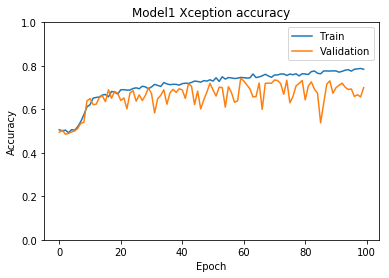

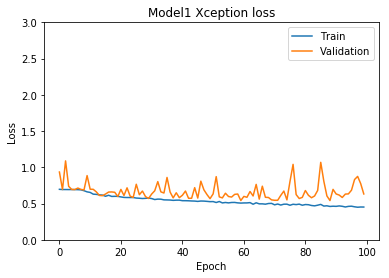

In [40]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model1 Xception accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model1 Xception loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

As you can see from above accuracy and loss graph, accuracy and loss of traning-set increse and decrese respectively quite smooth. On the other hand, even accuracy and loss of the validation-set are fructuate but they seem to increse and decrese respectively so I decided to try to <b>train this model further another 100 epochs</b>.

#### Go further with Model 1 (Xception pretraining model)

In [15]:
# Set next epoch starting
N_EPOCHS = 100

# Model path after traning 200 epochs
fur_weight_model1="200_xcep.hdf5"

# History path after traning 200 epochs
fur_his_model1="200_xcep_his"

# Model path for the epoch the has minimum val_loss
best_weight_model1_fur="best_xcep_fur.hdf5"

# Create model checkpoint when it has minimum val_loss
checkpointf1 = ModelCheckpoint(best_weight_model1_fur, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
cbf1 = [checkpointf1]

In [23]:
# Load architecture and weight from the last 100 epochs training
model1 = load_model(last_weight_model1)

# Start timing
start = time.time()

# Training
print('Training further the model1 Xception ...')
historyf1 = model1.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = cbf1,
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save last model
model1.save(fur_weight_model1)

# Save the history
with open(fur_his_model1, 'wb') as file_pi:
    pickle.dump(historyf1.history, file_pi)

Training further the model1 Xception ...
Epoch 101/200
281/281 [==============================] - 242s 860ms/step - loss: 0.4522 - acc: 0.7838 - val_loss: 0.6373 - val_acc: 0.7003

Epoch 00101: val_loss improved from inf to 0.63731, saving model to best_xcep_fur.hdf5
Epoch 102/200
281/281 [==============================] - 236s 841ms/step - loss: 0.4597 - acc: 0.7754 - val_loss: 0.6687 - val_acc: 0.6584

Epoch 00102: val_loss did not improve from 0.63731
Epoch 103/200
281/281 [==============================] - 234s 832ms/step - loss: 0.4473 - acc: 0.7863 - val_loss: 0.7218 - val_acc: 0.6152

Epoch 00103: val_loss did not improve from 0.63731
Epoch 104/200
281/281 [==============================] - 234s 831ms/step - loss: 0.4484 - acc: 0.7818 - val_loss: 0.6169 - val_acc: 0.7035

Epoch 00104: val_loss improved from 0.63731 to 0.61692, saving model to best_xcep_fur.hdf5
Epoch 105/200
281/281 [==============================] - 233s 831ms/step - loss: 0.4510 - acc: 0.7829 - val_loss: 0.722


Epoch 00142: val_loss did not improve from 0.58728
Epoch 143/200
281/281 [==============================] - 233s 830ms/step - loss: 0.3985 - acc: 0.8167 - val_loss: 0.8166 - val_acc: 0.6900

Epoch 00143: val_loss did not improve from 0.58728
Epoch 144/200
281/281 [==============================] - 233s 830ms/step - loss: 0.4151 - acc: 0.8201 - val_loss: 1.0781 - val_acc: 0.6900

Epoch 00144: val_loss did not improve from 0.58728
Epoch 145/200
281/281 [==============================] - 233s 830ms/step - loss: 0.3858 - acc: 0.8241 - val_loss: 0.7312 - val_acc: 0.7204

Epoch 00145: val_loss did not improve from 0.58728
Epoch 146/200
281/281 [==============================] - 233s 830ms/step - loss: 0.3887 - acc: 0.8261 - val_loss: 0.8767 - val_acc: 0.6934

Epoch 00146: val_loss did not improve from 0.58728
Epoch 147/200
281/281 [==============================] - 233s 831ms/step - loss: 0.3849 - acc: 0.8178 - val_loss: 1.6613 - val_acc: 0.6584

Epoch 00147: val_loss did not improve from 0


Epoch 00185: val_loss did not improve from 0.58728
Epoch 186/200
281/281 [==============================] - 233s 830ms/step - loss: 0.3309 - acc: 0.8565 - val_loss: 0.9324 - val_acc: 0.6644

Epoch 00186: val_loss did not improve from 0.58728
Epoch 187/200
281/281 [==============================] - 233s 829ms/step - loss: 0.3196 - acc: 0.8612 - val_loss: 1.0088 - val_acc: 0.6590

Epoch 00187: val_loss did not improve from 0.58728
Epoch 188/200
281/281 [==============================] - 233s 829ms/step - loss: 0.3198 - acc: 0.8601 - val_loss: 0.7756 - val_acc: 0.6934

Epoch 00188: val_loss did not improve from 0.58728
Epoch 189/200
281/281 [==============================] - 233s 829ms/step - loss: 0.3176 - acc: 0.8652 - val_loss: 0.9584 - val_acc: 0.6590

Epoch 00189: val_loss did not improve from 0.58728
Epoch 190/200
281/281 [==============================] - 233s 829ms/step - loss: 0.3172 - acc: 0.8663 - val_loss: 1.4198 - val_acc: 0.6914

Epoch 00190: val_loss did not improve from 0

This training model 1 used total time 23,350 seconds for 100 epochs and average time 233.5 seconds/epoch. We ended up with 124th as the best epoch. The best epoch given minimum loss equal to 0.58728 that was <b>higher loss than the last best model</b> that given loss equal to 0.54127.

Then, I plotted accuracy and loss value for each epoch into line graph as you can see below.

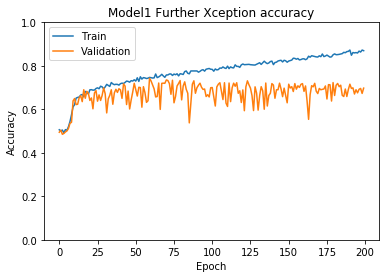

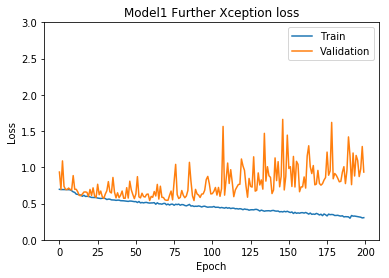

In [24]:
with open(last_his_model1, "rb") as input_file:
     his_model_1 = pd.DataFrame(pickle.load(input_file))

with open(fur_his_model1, "rb") as input_file:
     his_model_1_fur = pd.DataFrame(pickle.load(input_file))

# Plot training & validation accuracy values
plt.figure()
plt.plot(pd.concat([his_model_1['acc'], his_model_1_fur['acc']], axis=0, ignore_index=True))
plt.plot(pd.concat([his_model_1['val_acc'], his_model_1_fur['val_acc']], axis=0, ignore_index=True))
plt.title('Model1 Further Xception accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(pd.concat([his_model_1['loss'], his_model_1_fur['loss']], axis=0, ignore_index=True))
plt.plot(pd.concat([his_model_1['val_loss'], his_model_1_fur['val_loss']], axis=0, ignore_index=True))
plt.title('Model1 Further Xception loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

From the above loss graph, we can see that trend of loss value of validation set was already incresing that mean <b>overfitting of the model</b>. And as I already mention that the lowest validation loss of further training model is higher than the lowest validation loss from the last best model.

### Training Model 2 (Xception pretraining model (freezing weight))

In [26]:
# Start timing
start = time.time()

# Training
print('Training the model2 Xception freezing weight ...')
history2 = model2.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = cb2,
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save last model
model2.save(last_weight_model2)

# Save the history
with open(last_his_model2, 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

Training the model2 Xception freezing weight ...
Epoch 1/100
281/281 [==============================] - 75s 265ms/step - loss: 4.3976 - acc: 0.5151 - val_loss: 0.7488 - val_acc: 0.5236

Epoch 00001: val_loss improved from inf to 0.74878, saving model to best_xcep_freeze.hdf5
Epoch 2/100
281/281 [==============================] - 63s 225ms/step - loss: 0.7330 - acc: 0.5318 - val_loss: 0.6906 - val_acc: 0.5303

Epoch 00002: val_loss improved from 0.74878 to 0.69060, saving model to best_xcep_freeze.hdf5
Epoch 3/100
281/281 [==============================] - 63s 225ms/step - loss: 0.6986 - acc: 0.5412 - val_loss: 0.6879 - val_acc: 0.5195

Epoch 00003: val_loss improved from 0.69060 to 0.68787, saving model to best_xcep_freeze.hdf5
Epoch 4/100
281/281 [==============================] - 63s 225ms/step - loss: 0.6933 - acc: 0.5687 - val_loss: 0.7749 - val_acc: 0.5276

Epoch 00004: val_loss did not improve from 0.68787
Epoch 5/100
281/281 [==============================] - 63s 225ms/step - lo

281/281 [==============================] - 63s 226ms/step - loss: 0.6821 - acc: 0.6072 - val_loss: 3.1291 - val_acc: 0.5492

Epoch 00086: val_loss did not improve from 0.68076
Epoch 87/100
281/281 [==============================] - 63s 225ms/step - loss: 0.6817 - acc: 0.6130 - val_loss: 2.2973 - val_acc: 0.5451

Epoch 00087: val_loss did not improve from 0.68076
Epoch 88/100
281/281 [==============================] - 63s 226ms/step - loss: 0.6746 - acc: 0.6186 - val_loss: 3.4884 - val_acc: 0.5431

Epoch 00088: val_loss did not improve from 0.68076
Epoch 89/100
281/281 [==============================] - 63s 226ms/step - loss: 0.6853 - acc: 0.6061 - val_loss: 1.7501 - val_acc: 0.5647

Epoch 00089: val_loss did not improve from 0.68076
Epoch 90/100
281/281 [==============================] - 63s 226ms/step - loss: 0.6866 - acc: 0.6025 - val_loss: 2.5434 - val_acc: 0.5512

Epoch 00090: val_loss did not improve from 0.68076
Epoch 91/100
281/281 [==============================] - 63s 225ms/st

This training model 2 used total time 6,349 seconds for 100 epochs, and average time 63.5 seconds/epoch. We ended up with <b>6th as the best epoch</b>.

Then, I plotted accuracy and loss value for each epoch into line graph as you can see below.

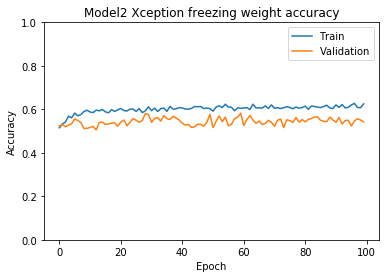

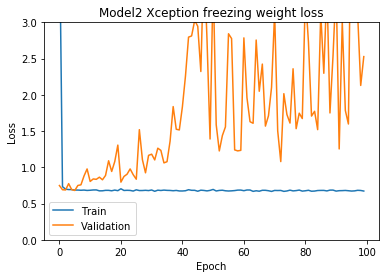

In [42]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model2 Xception freezing weight accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model2 Xception freezing weight loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

From this model, accuracy of validation-set didn't much and the loss value showed that <b>this model overfit very quickly</b> (as you can see from the minimum validation loss is at 5th epoch).

### Training Model 3 (InceptionResNetV2 pretraining model)

In [28]:
# Start timing
start = time.time()

# Training
print('Training the model3 inceptionV2 ...')
history3 = model3.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = cb3,
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save last model
model3.save(last_weight_model3)

# Save the history
with open(last_his_model3, 'wb') as file_pi:
    pickle.dump(history3.history, file_pi)

Training the model3 inceptionV2 ...
Epoch 1/100
281/281 [==============================] - 292s 1s/step - loss: 0.7992 - acc: 0.5153 - val_loss: 7.8704 - val_acc: 0.4973

Epoch 00001: val_loss improved from inf to 7.87041, saving model to best_inceptionV2.hdf5
Epoch 2/100
281/281 [==============================] - 249s 887ms/step - loss: 0.6836 - acc: 0.5943 - val_loss: 1.4736 - val_acc: 0.5377

Epoch 00002: val_loss improved from 7.87041 to 1.47357, saving model to best_inceptionV2.hdf5
Epoch 3/100
281/281 [==============================] - 250s 889ms/step - loss: 0.6680 - acc: 0.6125 - val_loss: 2.6551 - val_acc: 0.5094

Epoch 00003: val_loss did not improve from 1.47357
Epoch 4/100
281/281 [==============================] - 250s 889ms/step - loss: 0.6469 - acc: 0.6386 - val_loss: 0.7945 - val_acc: 0.5822

Epoch 00004: val_loss improved from 1.47357 to 0.79449, saving model to best_inceptionV2.hdf5
Epoch 5/100
281/281 [==============================] - 250s 888ms/step - loss: 0.6615 

281/281 [==============================] - 250s 889ms/step - loss: 0.4913 - acc: 0.7602 - val_loss: 0.5945 - val_acc: 0.7143

Epoch 00085: val_loss did not improve from 0.57242
Epoch 86/100
281/281 [==============================] - 250s 889ms/step - loss: 0.4956 - acc: 0.7527 - val_loss: 1.8325 - val_acc: 0.6105

Epoch 00086: val_loss did not improve from 0.57242
Epoch 87/100
281/281 [==============================] - 250s 889ms/step - loss: 0.4958 - acc: 0.7549 - val_loss: 0.6443 - val_acc: 0.6691

Epoch 00087: val_loss did not improve from 0.57242
Epoch 88/100
281/281 [==============================] - 250s 889ms/step - loss: 0.5045 - acc: 0.7569 - val_loss: 0.7554 - val_acc: 0.6388

Epoch 00088: val_loss did not improve from 0.57242
Epoch 89/100
281/281 [==============================] - 250s 889ms/step - loss: 0.4947 - acc: 0.7540 - val_loss: 1.2010 - val_acc: 0.6570

Epoch 00089: val_loss did not improve from 0.57242
Epoch 90/100
281/281 [==============================] - 250s 88

This training model 3 used total time 25,425 seconds for 100 epochs, and average time 254.2 seconds/epoch. We ended up with <b>36th as the best epoch</b>.

Then, I plotted accuracy and loss value for each epoch into line graph as you can see below.

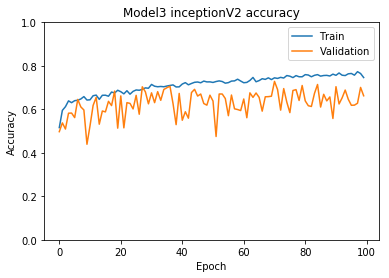

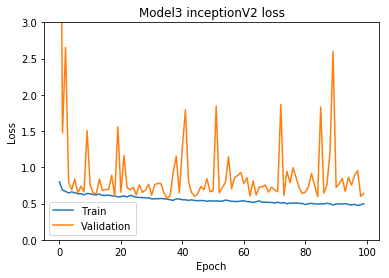

In [43]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model3 inceptionV2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model3 inceptionV2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

For this model, accuracy and loss of traning-set increse and decrese respectively. On the other hand, even accuracy of the validation-set are fructuate but loss value tend to decrese so I decided to try to <b>train this model further another 100 epochs</b>.

#### Go further with Model 3  (InceptionResNetV2 pretraining model)

In [16]:
# Model path after traning 200 epochs
fur_weight_model3="200_inceptionV2.hdf5"

# History path after traning 200 epochs
fur_his_model3="200_inceptionV2_his"

# Model path for the epoch the has minimum val_loss
best_weight_model3_fur="best_inceptionV2_fur.hdf5"

# Create model checkpoint when it has minimum val_loss
checkpointf3 = ModelCheckpoint(best_weight_model3_fur, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
cbf3 = [checkpointf3]

In [26]:
# Load architecture and weight from the last 100 epochs training
model3 = load_model(last_weight_model3)

# Start timing
start = time.time()

# Training
print('Training further the model3 inceptionV2 ...')
historyf3 = model3.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = cbf3,
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save last model
model3.save(fur_weight_model3)

# Save the history
with open(fur_his_model3, 'wb') as file_pi:
    pickle.dump(historyf3.history, file_pi)

Training further the model3 inceptionV2 ...
Epoch 101/200
281/281 [==============================] - 280s 998ms/step - loss: 0.4762 - acc: 0.7714 - val_loss: 0.6336 - val_acc: 0.7055

Epoch 00101: val_loss improved from inf to 0.63360, saving model to best_inceptionV2_fur.hdf5
Epoch 102/200
281/281 [==============================] - 249s 887ms/step - loss: 0.4887 - acc: 0.7616 - val_loss: 0.7244 - val_acc: 0.6577

Epoch 00102: val_loss did not improve from 0.63360
Epoch 103/200
281/281 [==============================] - 250s 888ms/step - loss: 0.4749 - acc: 0.7667 - val_loss: 0.7552 - val_acc: 0.5761

Epoch 00103: val_loss did not improve from 0.63360
Epoch 104/200
281/281 [==============================] - 249s 888ms/step - loss: 0.4859 - acc: 0.7693 - val_loss: 0.5773 - val_acc: 0.6941

Epoch 00104: val_loss improved from 0.63360 to 0.57729, saving model to best_inceptionV2_fur.hdf5
Epoch 105/200
281/281 [==============================] - 250s 888ms/step - loss: 0.4849 - acc: 0.7667 

281/281 [==============================] - 250s 888ms/step - loss: 0.4127 - acc: 0.8112 - val_loss: 0.9306 - val_acc: 0.6732

Epoch 00186: val_loss did not improve from 0.57729
Epoch 187/200
281/281 [==============================] - 250s 888ms/step - loss: 0.3818 - acc: 0.8292 - val_loss: 0.6962 - val_acc: 0.7008

Epoch 00187: val_loss did not improve from 0.57729
Epoch 188/200
281/281 [==============================] - 249s 888ms/step - loss: 0.3929 - acc: 0.8187 - val_loss: 0.7797 - val_acc: 0.6887

Epoch 00188: val_loss did not improve from 0.57729
Epoch 189/200
281/281 [==============================] - 250s 889ms/step - loss: 0.3980 - acc: 0.8210 - val_loss: 1.2756 - val_acc: 0.6611

Epoch 00189: val_loss did not improve from 0.57729
Epoch 190/200
281/281 [==============================] - 250s 889ms/step - loss: 0.3790 - acc: 0.8334 - val_loss: 0.8661 - val_acc: 0.7049

Epoch 00190: val_loss did not improve from 0.57729
Epoch 191/200
281/281 [==============================] - 25

This training model 3 used total time 25,201 seconds for 100 epochs and average time 252 seconds/epoch. We ended up with 104th as the best epoch. The best epoch given minimum loss equal to 0.57729 that was <b>higher than the last best model</b> that given loss equal to 0.57242.

Then, I plotted accuracy and loss value for each epoch into line graph as you can see below.

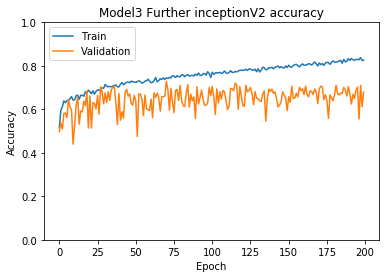

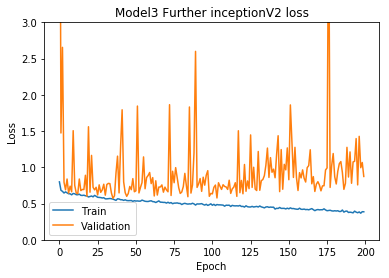

In [27]:
with open(last_his_model3, "rb") as input_file:
     his_model_3 = pd.DataFrame(pickle.load(input_file))

with open(fur_his_model3, "rb") as input_file:
     his_model_3_fur = pd.DataFrame(pickle.load(input_file))

# Plot training & validation accuracy values
plt.figure()
plt.plot(pd.concat([his_model_3['acc'], his_model_3_fur['acc']], axis=0, ignore_index=True))
plt.plot(pd.concat([his_model_3['val_acc'], his_model_3_fur['val_acc']], axis=0, ignore_index=True))
plt.title('Model3 Further inceptionV2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(pd.concat([his_model_3['loss'], his_model_3_fur['loss']], axis=0, ignore_index=True))
plt.plot(pd.concat([his_model_3['val_loss'], his_model_3_fur['val_loss']], axis=0, ignore_index=True))
plt.title('Model3 Further inceptionV2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

From the above loss graph, we can see that trend of loss value of validation set was already incresing that mean <b>overfitting of the model.</b> And as I already mention that the lowest validation loss of further training model is higher than the lowest validation loss from the last best model.

### Training Model 4 (InceptionResNetV2 pretraining model (freezing weight))

In [30]:
# Start timing
start = time.time()

# Training
print('Training the model4 inceptionV2 freezing weight...')
history4 = model4.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = cb4,
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save last model
model4.save(last_weight_model4)

# Save the history
with open(last_his_model4, 'wb') as file_pi:
    pickle.dump(history4.history, file_pi)

Training the model4 inceptionV2 freezing weight...
Epoch 1/100
281/281 [==============================] - 95s 340ms/step - loss: 1.0832 - acc: 0.5425 - val_loss: 0.7696 - val_acc: 0.5344

Epoch 00001: val_loss improved from inf to 0.76956, saving model to best_inceptionV2_freeze.hdf5
Epoch 2/100
281/281 [==============================] - 77s 276ms/step - loss: 0.7189 - acc: 0.5478 - val_loss: 0.7833 - val_acc: 0.5249

Epoch 00002: val_loss did not improve from 0.76956
Epoch 3/100
281/281 [==============================] - 77s 275ms/step - loss: 0.6882 - acc: 0.5672 - val_loss: 0.9812 - val_acc: 0.5067

Epoch 00003: val_loss did not improve from 0.76956
Epoch 4/100
281/281 [==============================] - 77s 275ms/step - loss: 0.6895 - acc: 0.5443 - val_loss: 0.6944 - val_acc: 0.5580

Epoch 00004: val_loss improved from 0.76956 to 0.69443, saving model to best_inceptionV2_freeze.hdf5
Epoch 5/100
281/281 [==============================] - 77s 275ms/step - loss: 0.6783 - acc: 0.5743 - 


Epoch 00043: val_loss did not improve from 0.69443
Epoch 44/100
281/281 [==============================] - 78s 277ms/step - loss: 0.6578 - acc: 0.6099 - val_loss: 0.8283 - val_acc: 0.5330

Epoch 00044: val_loss did not improve from 0.69443
Epoch 45/100
281/281 [==============================] - 77s 276ms/step - loss: 0.6525 - acc: 0.6150 - val_loss: 0.8297 - val_acc: 0.5458

Epoch 00045: val_loss did not improve from 0.69443
Epoch 46/100
281/281 [==============================] - 78s 276ms/step - loss: 0.6609 - acc: 0.6005 - val_loss: 0.9981 - val_acc: 0.5317

Epoch 00046: val_loss did not improve from 0.69443
Epoch 47/100
281/281 [==============================] - 78s 277ms/step - loss: 0.6533 - acc: 0.6074 - val_loss: 0.8830 - val_acc: 0.5425

Epoch 00047: val_loss did not improve from 0.69443
Epoch 48/100
281/281 [==============================] - 77s 276ms/step - loss: 0.6575 - acc: 0.6081 - val_loss: 1.1054 - val_acc: 0.5209

Epoch 00048: val_loss did not improve from 0.69443
Epo

This training model 4 used total time 7,794 seconds for 100 epochs, and average time 77.9 seconds/epoch. We ended up with <b>3rd as the best epoch</b>.

Then, I plotted accuracy and loss value for each epoch into line graph as you can see below.

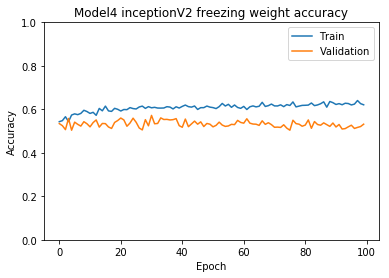

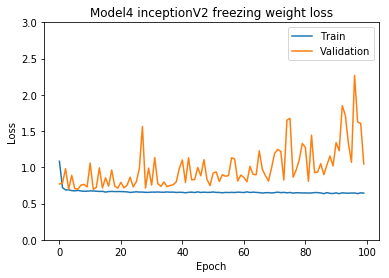

In [45]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model4 inceptionV2 freezing weight accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model4 inceptionV2 freezing weight loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

For this model, accuracy of validation-set didn't much and the loss value showed that <b>this model overfit very quickly</b> as Model 2 (as you can see from the minimum validation loss is at 3rd epoch).

### Training Model 5 (4 convolutional layers model)

In [32]:
# Start timing
start = time.time()

# Training
print('Training the model5 4-Conv layers...')
history5 = model5.fit_generator(
    generator = train_flow,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = cb5,
    validation_data = valid_flow,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save last model
model5.save(last_weight_model5)

# Save the history
with open(last_his_model5, 'wb') as file_pi:
    pickle.dump(history5.history, file_pi)

Training the model5 4-Conv layers...
Epoch 1/100
281/281 [==============================] - 49s 174ms/step - loss: 0.7021 - acc: 0.5100 - val_loss: 0.6937 - val_acc: 0.5027

Epoch 00001: val_loss improved from inf to 0.69365, saving model to best_4conv.hdf5
Epoch 2/100
281/281 [==============================] - 33s 119ms/step - loss: 0.6940 - acc: 0.4935 - val_loss: 0.6932 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69365 to 0.69321, saving model to best_4conv.hdf5
Epoch 3/100
281/281 [==============================] - 33s 118ms/step - loss: 0.6940 - acc: 0.4958 - val_loss: 0.6932 - val_acc: 0.4987

Epoch 00003: val_loss improved from 0.69321 to 0.69315, saving model to best_4conv.hdf5
Epoch 4/100
281/281 [==============================] - 35s 126ms/step - loss: 0.6939 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.4987

Epoch 00004: val_loss did not improve from 0.69315
Epoch 5/100
281/281 [==============================] - 33s 117ms/step - loss: 0.6936 - acc: 0.4929 - val

281/281 [==============================] - 36s 126ms/step - loss: 0.6879 - acc: 0.5465 - val_loss: 0.6931 - val_acc: 0.5559

Epoch 00085: val_loss did not improve from 0.68273
Epoch 86/100
281/281 [==============================] - 34s 122ms/step - loss: 0.6893 - acc: 0.5407 - val_loss: 0.6873 - val_acc: 0.5586

Epoch 00086: val_loss did not improve from 0.68273
Epoch 87/100
281/281 [==============================] - 32s 114ms/step - loss: 0.6888 - acc: 0.5463 - val_loss: 0.6943 - val_acc: 0.5553

Epoch 00087: val_loss did not improve from 0.68273
Epoch 88/100
281/281 [==============================] - 33s 116ms/step - loss: 0.6896 - acc: 0.5431 - val_loss: 0.6920 - val_acc: 0.5135

Epoch 00088: val_loss did not improve from 0.68273
Epoch 89/100
281/281 [==============================] - 33s 118ms/step - loss: 0.6908 - acc: 0.5334 - val_loss: 0.6899 - val_acc: 0.5364

Epoch 00089: val_loss did not improve from 0.68273
Epoch 90/100
281/281 [==============================] - 33s 119ms/st

This training model 5 used total time 3,400 seconds for 100 epochs, and average time 34.0 seconds/epoch. We ended up with <b>24th as the best epoch</b>.

Then, I plotted accuracy and loss value for each epoch into line graph as you can see below.

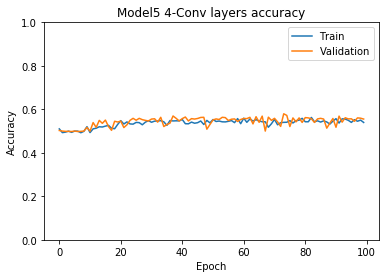

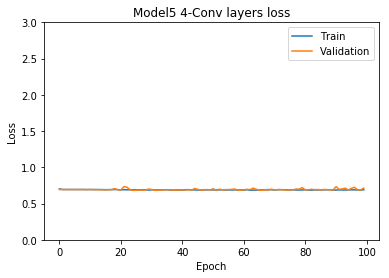

In [46]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Model5 4-Conv layers accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model5 4-Conv layers loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

This model didn't tend to have more accuracy or even less loss.

## 6. Evaluation

I modified function from Sakari's notebook (Demo 11) by adding calculation for <b>Sensitivity, Specification, and False negative rate</b>. I use this function to showed efficiecy of each model by using the same validation flow.

<a href="https://en.wikipedia.org/wiki/Sensitivity_and_specificity">(From this link)</a> Normally, we will consider positive as sick people (1 in my case) and negative to healthy people (0 in my case). So, I had to set the label of 'confusion_matrix' function as [1,0] to get the correct definition of False negative rate as I want.

In [17]:
# Function to display confusion matrix, classification report, accuracy, specification, sensitivity, and false negative
def display_results(path, flow):
    global valid_flow, valid_test_generator
     
    # Reinitial valid_flow
    valid_flow = valid_test_generator.flow_from_dataframe(
        dataframe = df_val_balance,
        directory = balance_dir,
        has_ext = False,
        x_col = 'image', 
        y_col = 'level', 
        target_size = (IMAGE_SIZE, IMAGE_SIZE), 
        classes = [0, 1], 
        class_mode = 'binary', 
        batch_size = BATCH_SIZE, 
        shuffle = False)
    
    # Load model from given path
    m = load_model(path)
    
    # Get the true and predicted values
    y_true = flow.classes
    predict = m.predict_generator(flow, steps=len(flow), verbose=1)
    y_pred = 1*(predict > 0.5)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        print('Confusion matrix:')
        print(cm)
        print('')
        
        # Calculate accuracy
        a = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.4f}'.format(a))
        print('')
        
        # Calculate Sensitivity
        sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
        print('Sensitivity: {:.4f}'.format(sensitivity))
        print('')
        
        # Calculate Specificity
        specificity = cm[1,1]/(cm[1,0]+cm[1,1])
        print('Specificity: {:.4f}'.format(specificity))
        print('')
        
        # Calculate False Negative Rate
        print('False Negative Rate: {:.4f}'.format(1-sensitivity))
        print('')
        
        # Display classification report
        cr = classification_report(y_true, y_pred)
        print('Classification report:')
        print(cr)
    
    # Clear tensorflow backend session and delete m variable
    K.clear_session()
    del m

### Selection the best of all

Show efficiency of each model after training 100 epochs (200 epochs for some model).

In [32]:
print('**** VALIDATION SET ****')
print('')

# Display evaluation of the last model
print('Result from the LAST model1 Xception')
display_results(last_weight_model1, valid_flow)
print('=====================================')

print('Result from the LAST further model1 Xception')
display_results(fur_weight_model1, valid_flow)
print('=====================================')

print('Result from the LAST model2 Xception freezing weight')
display_results(last_weight_model2, valid_flow)
print('=====================================')

print('Result from the LAST model3 InceptionV2')
display_results(last_weight_model3, valid_flow)
print('=====================================')

print('Result from the LAST further model3 InceptionV2')
display_results(fur_weight_model3, valid_flow)
print('=====================================')

print('Result from the LAST model4 InceptionV2 freezing weight')
display_results(last_weight_model4, valid_flow)
print('=====================================')

print('Result from the LAST model5 4-Conv layers')
display_results(last_weight_model5, valid_flow)

**** VALIDATION SET ****

Result from the LAST model1 Xception
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 15s 163ms/step
Confusion matrix:
[[491 259]
 [189 561]]

Accuracy: 0.7013

Sensitivity: 0.6547

Specificity: 0.7480

False Negative Rate: 0.3453

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       750
           1       0.72      0.65      0.69       750

   micro avg       0.70      0.70      0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500

Result from the LAST further model1 Xception
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 16s 166ms/step
Confusion matrix:
[[514 236]
 [215 535]]

Accuracy: 0.6993

Sensitivity: 0.6853

Specificity: 0.7133

False Negative Rate: 0.3147

Classification report:
              precision    recall  f1-score   support

      

C:\Users\Pasin\Anaconda3\envs\py36\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


94/94 [==============================] - 18s 190ms/step
Confusion matrix:
[[332 418]
 [270 480]]

Accuracy: 0.5413

Sensitivity: 0.4427

Specificity: 0.6400

False Negative Rate: 0.5573

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       750
           1       0.55      0.44      0.49       750

   micro avg       0.54      0.54      0.54      1500
   macro avg       0.54      0.54      0.54      1500
weighted avg       0.54      0.54      0.54      1500

Result from the LAST model3 InceptionV2
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 24s 253ms/step
Confusion matrix:
[[353 397]
 [112 638]]

Accuracy: 0.6607

Sensitivity: 0.4707

Specificity: 0.8507

False Negative Rate: 0.5293

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.85      0.71       750
           1       0.76      0.47      0.58       750

   micr

C:\Users\Pasin\Anaconda3\envs\py36\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


94/94 [==============================] - 32s 345ms/step
Confusion matrix:
[[645 105]
 [594 156]]

Accuracy: 0.5340

Sensitivity: 0.8600

Specificity: 0.2080

False Negative Rate: 0.1400

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.21      0.31       750
           1       0.52      0.86      0.65       750

   micro avg       0.53      0.53      0.53      1500
   macro avg       0.56      0.53      0.48      1500
weighted avg       0.56      0.53      0.48      1500

Result from the LAST model5 4-Conv layers
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 6s 63ms/step
Confusion matrix:
[[278 472]
 [197 553]]

Accuracy: 0.5540

Sensitivity: 0.3707

Specificity: 0.7373

False Negative Rate: 0.6293

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       750
           1       0.59      0.37      0.45       750

   micr

Show efficiency of each model from the epoch that given the minimum validation loss while training.

In [33]:
print('VALIDATION SET')
print('')

# Display evaluation of the best model
print('Result from the BEST model1 Xception')
display_results(best_weight_model1, valid_flow)
print('=====================================')

print('Result from the BEST further model1 Xception')
display_results(best_weight_model1_fur, valid_flow)
print('=====================================')

print('Result from the BEST model2 Xception freezing weight')
display_results(best_weight_model2, valid_flow)
print('=====================================')

print('Result from the BEST model3 InceptionV2')
display_results(best_weight_model3, valid_flow)
print('=====================================')

print('Result from the BEST further model3 InceptionV2')
display_results(best_weight_model3_fur, valid_flow)
print('=====================================')

print('Result from the BEST model4 InceptionV2 freezing weight')
display_results(best_weight_model4, valid_flow)
print('=====================================')

print('Result from the BEST model5 4-Conv layers')
display_results(best_weight_model5, valid_flow)

VALIDATION SET

Result from the BEST model1 Xception
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 16s 167ms/step
Confusion matrix:
[[541 209]
 [193 557]]

Accuracy: 0.7320

Sensitivity: 0.7213

Specificity: 0.7427

False Negative Rate: 0.2787

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       750
           1       0.74      0.72      0.73       750

   micro avg       0.73      0.73      0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.73      0.73      1500

Result from the BEST further model1 Xception
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 15s 164ms/step
Confusion matrix:
[[432 318]
 [ 85 665]]

Accuracy: 0.7313

Sensitivity: 0.5760

Specificity: 0.8867

False Negative Rate: 0.4240

Classification report:
              precision    recall  f1-score   support

           0    

C:\Users\Pasin\Anaconda3\envs\py36\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


94/94 [==============================] - 18s 190ms/step
Confusion matrix:
[[223 527]
 [141 609]]

Accuracy: 0.5547

Sensitivity: 0.2973

Specificity: 0.8120

False Negative Rate: 0.7027

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.81      0.65       750
           1       0.61      0.30      0.40       750

   micro avg       0.55      0.55      0.55      1500
   macro avg       0.57      0.55      0.52      1500
weighted avg       0.57      0.55      0.52      1500

Result from the BEST model3 InceptionV2
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 23s 244ms/step
Confusion matrix:
[[442 308]
 [142 608]]

Accuracy: 0.7000

Sensitivity: 0.5893

Specificity: 0.8107

False Negative Rate: 0.4107

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       750
           1       0.76      0.59      0.66       750

   micr

C:\Users\Pasin\Anaconda3\envs\py36\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


94/94 [==============================] - 32s 342ms/step
Confusion matrix:
[[418 332]
 [327 423]]

Accuracy: 0.5607

Sensitivity: 0.5573

Specificity: 0.5640

False Negative Rate: 0.4427

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       750
           1       0.56      0.56      0.56       750

   micro avg       0.56      0.56      0.56      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.56      0.56      1500

Result from the BEST model5 4-Conv layers
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 6s 66ms/step
Confusion matrix:
[[352 398]
 [267 483]]

Accuracy: 0.5567

Sensitivity: 0.4693

Specificity: 0.6440

False Negative Rate: 0.5307

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.64      0.59       750
           1       0.57      0.47      0.51       750

   micr

As the result, Top 3 best models (consider from high accuracy) are:
    1. BEST Model 1 Xception pretraining model (89th epoch)
        * Accuracy = 73.20%
        * False Negative Rate = 27.87%
    2. BEST futher Model 1 Xception pretraining model (124th epoch)
        * Accuracy = 73.13%
        * False Negative Rate = 42.40%
    3. BEST Model 3 InceptionResNetV2 pretraining model (36th epoch)
        * Accuracy = 70.00%
        * False Negative Rate = 41.07%
    

From above comparison, the best model that I selected was <b> Model 1 Xception pretraining model (89th epoch)</b> because  it has highest average accuracy score and lowest False Negative rate.

### Comparison with training by imbalance dataset

As I already mentioned before, one of my hypothesis is that traning with balanced dataset should given a better result than training with imbalance dataset that lead model to has bias. Now, I will try to <b>train my best model (<b>Xception model</b>) with imbalance dataset</b> that I already created.

So, I created new flow for imbalanced training-set and validation-set.

In [85]:
# Training flow (imbalance)
print('Training flow (imbalance):')
train_flow_unbalance = train_generator.flow_from_dataframe(
    dataframe = df_unbalance[:SPLIT],
    directory = unbalance_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    seed = 1)

# Validation flow (imbalance)
print('Validation flow (imbalance):')
valid_flow_unbalance = valid_test_generator.flow_from_dataframe(
    dataframe = df_unbalance[SPLIT:],
    directory = unbalance_dir,
    has_ext = False,
    x_col = 'image', 
    y_col = 'level', 
    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
    classes = [0, 1], 
    class_mode = 'binary', 
    batch_size = BATCH_SIZE, 
    shuffle = False)

print('')
print("How many records for each class (imbalance)")
print(df_unbalance[:SPLIT]['level'].value_counts())

Training flow (imbalance):
Found 768 images belonging to 2 classes.
Validation flow (imbalance):
Found 239 images belonging to 2 classes.

How many records for each class (imbalance)
0    3334
1    1166
Name: level, dtype: int64


I reinitial my best architecture model with the same weight from ImageNet pretraining and them train it by 100 epoch.

In [19]:
# Reinitial the best model
base_model1_unbal = Xception(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
x_model1_unbal = Dense(1)(base_model1_unbal.get_layer('avg_pool').output)
y_model1_unbal = Activation('sigmoid')(x_model1_unbal)
unbalance_model = Model(inputs = base_model1_unbal.input, outputs = y_model1_unbal)

# Optimizer, loss and metrics
unbalance_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# Path for history and weight after trainging
last_weight_unbal_model = "100_unbal.hdf5"
last_his_unbal_model = "100_unbal_his"
best_weight_unbal_model = "best_unbal.hdf5"

# Create model checkpoint
cp_unbal = ModelCheckpoint(best_weight_unbal_model, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

N_EPOCHS = 0

In [21]:
# Start timing
start = time.time()

# Training
print('Training the model with unbalace dataset...')
history_unbal = unbalance_model.fit_generator(
    generator = train_flow_unbalance,
    steps_per_epoch = TRAIN_STEPS,
    epochs = N_EPOCHS + EPOCHS,
    initial_epoch = N_EPOCHS,
    verbose = 1,
    callbacks = [cp_unbal],
    validation_data = valid_flow_unbalance,
    validation_steps = VALID_STEPS)
stop = time.time()
etime = stop - start
print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, EPOCHS, etime/EPOCHS))

# Save the last model
unbalance_model.save(last_weight_unbal_model)

# Save the history
with open(last_his_unbal_model, 'wb') as file_pi:
    pickle.dump(history_unbal.history, file_pi)

Training the model with unbalace dataset...
Epoch 1/100
281/281 [==============================] - 253s 900ms/step - loss: 0.6163 - acc: 0.7327 - val_loss: 1.2433 - val_acc: 0.6619

Epoch 00001: val_loss improved from inf to 1.24329, saving model to best_unbal.hdf5
Epoch 2/100
281/281 [==============================] - 231s 824ms/step - loss: 0.5170 - acc: 0.7696 - val_loss: 1.4088 - val_acc: 0.7227

Epoch 00002: val_loss did not improve from 1.24329
Epoch 3/100
281/281 [==============================] - 232s 825ms/step - loss: 0.4729 - acc: 0.7916 - val_loss: 2.1885 - val_acc: 0.7402

Epoch 00003: val_loss did not improve from 1.24329
Epoch 4/100
281/281 [==============================] - 231s 823ms/step - loss: 0.4442 - acc: 0.8069 - val_loss: 0.9942 - val_acc: 0.6883

Epoch 00004: val_loss improved from 1.24329 to 0.99420, saving model to best_unbal.hdf5
Epoch 5/100
281/281 [==============================] - 231s 822ms/step - loss: 0.4222 - acc: 0.8145 - val_loss: 0.9157 - val_acc: 

281/281 [==============================] - 231s 824ms/step - loss: 0.0333 - acc: 0.9902 - val_loss: 2.7392 - val_acc: 0.7240

Epoch 00043: val_loss did not improve from 0.77351
Epoch 44/100
281/281 [==============================] - 231s 823ms/step - loss: 0.0381 - acc: 0.9882 - val_loss: 2.4273 - val_acc: 0.7139

Epoch 00044: val_loss did not improve from 0.77351
Epoch 45/100
281/281 [==============================] - 232s 824ms/step - loss: 0.0414 - acc: 0.9862 - val_loss: 2.3186 - val_acc: 0.7157

Epoch 00045: val_loss did not improve from 0.77351
Epoch 46/100
281/281 [==============================] - 231s 823ms/step - loss: 0.0392 - acc: 0.9882 - val_loss: 2.1968 - val_acc: 0.6835

Epoch 00046: val_loss did not improve from 0.77351
Epoch 47/100
281/281 [==============================] - 231s 823ms/step - loss: 0.0401 - acc: 0.9882 - val_loss: 2.6536 - val_acc: 0.7301

Epoch 00047: val_loss did not improve from 0.77351
Epoch 48/100
281/281 [==============================] - 231s 82

281/281 [==============================] - 231s 823ms/step - loss: 0.0130 - acc: 0.9962 - val_loss: 3.0428 - val_acc: 0.6795

Epoch 00086: val_loss did not improve from 0.77351
Epoch 87/100
281/281 [==============================] - 231s 823ms/step - loss: 0.0258 - acc: 0.9929 - val_loss: 2.9817 - val_acc: 0.7260

Epoch 00087: val_loss did not improve from 0.77351
Epoch 88/100
281/281 [==============================] - 231s 822ms/step - loss: 0.0126 - acc: 0.9958 - val_loss: 2.7277 - val_acc: 0.6808

Epoch 00088: val_loss did not improve from 0.77351
Epoch 89/100
281/281 [==============================] - 231s 823ms/step - loss: 0.0177 - acc: 0.9949 - val_loss: 3.0503 - val_acc: 0.7186

Epoch 00089: val_loss did not improve from 0.77351
Epoch 90/100
281/281 [==============================] - 231s 823ms/step - loss: 0.0127 - acc: 0.9960 - val_loss: 3.2878 - val_acc: 0.6651

Epoch 00090: val_loss did not improve from 0.77351
Epoch 91/100
281/281 [==============================] - 231s 82

I used the same balanced validation set to evaluate the model.

In [23]:
print('VALIDATION SET')
print('')

# Display evaluation of the best model that are trained by imbalanced dataset
print('Result from the LAST imbalance model')
display_results(last_weight_unbal_model, valid_flow)

print('Result from the BEST imbalance model')
display_results(best_weight_unbal_model, valid_flow)

VALIDATION SET

Result from the LAST unbalance model
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 16s 173ms/step
Confusion matrix:
[[337 413]
 [132 618]]

Accuracy: 0.6367

Sensitivity: 0.4493

Specificity: 0.8240

False Negative Rate: 0.5507

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.82      0.69       750
           1       0.72      0.45      0.55       750

   micro avg       0.64      0.64      0.64      1500
   macro avg       0.66      0.64      0.62      1500
weighted avg       0.66      0.64      0.62      1500

Result from the BEST unbalance model
Found 1500 images belonging to 2 classes.
94/94 [==============================] - 15s 162ms/step
Confusion matrix:
[[188 562]
 [ 40 710]]

Accuracy: 0.5987

Sensitivity: 0.2507

Specificity: 0.9467

False Negative Rate: 0.7493

Classification report:
              precision    recall  f1-score   support

           0       0.56 

From this result, you can see that the model with the same architechture but was trained by a imbalanced set <b>tend to predict more number of class that was higher amount in class distribution</b> (you can see from the confusion matrix metric). 

So, <b>I chosen the model that was trained by balanced dataset</b> as by best model. 

## 7. Results and Discussion

### Final model with test set

As same as the 'display_results' function that I define above, but this time I use test set (10,000 records) that is unseen data to evaluate my final model for getting the final score of my best model.

In [25]:
print('Result from the BEST model')
print('TEST SET')

# Load the final model from the given path
m_final = load_model(best_weight_model1)

# Get the true and predicted values
y_true = test_flow.classes
predict = m_final.predict_generator(test_flow, steps=len(test_flow), verbose=1)
y_pred = 1*(predict > 0.5)

# Calculate and print the metrics results
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Display Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print('Confusion matrix:')
    print(cm)
    print('')
    
    # Calculate Accuracy
    a = accuracy_score(y_true, y_pred)
    print('Accuracy: {:.4f}'.format(a))
    print('')

    # Calculate Sensitivity
    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Sensitivity: {:.4f}'.format(sensitivity))
    print('')

    # Calculate Specificity
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Specificity: {:.4f}'.format(specificity))
    print('')

    # Calculate False Negative
    print('False Negative Rate: {:.4f}'.format(1-sensitivity))
    print('')
    
    # Display Classification report
    cr = classification_report(y_true, y_pred)
    print('Classification report:')
    print(cr)

Result from the BEST model
TEST SET
625/625 [==============================] - 241s 385ms/step
Confusion matrix:
[[3567 1433]
 [1460 3540]]

Accuracy: 0.7107

Sensitivity: 0.7134

Specificity: 0.7080

False Negative Rate: 0.2866

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      5000
           1       0.71      0.71      0.71      5000

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



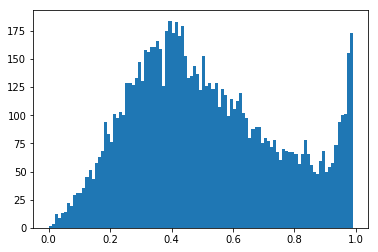

In [36]:
# Check the histogram of the predicted values
plt.hist(predict, bins = np.arange(0, 1, 0.01));

### ROC Curve

Then I use an ROC curve, that is a graph showing the performance of a classification model at all classification thresholds, to find new decision point that given the highest True positive value.

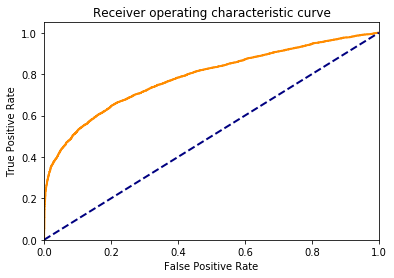

In [26]:
# Create ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, predict)

# Plot the ROC Curve
plt.plot(fpr, tpr, color='darkorange', lw = 2)
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show()

### Trying to change decision point

From my experiment, I got the <b>highest accuracy (72.14%)</b> by setting decision point equal to 0.6004, <b>but at this point it make we got lower Sensitivity and higher False Negative Rate</b>.


Finally, <b>I chosen 0.4605 as my new decision point</b> because I want the accuracy score still higher than 70% but by reducing the decision point let we get higher Sensitivity and lower False Negative Rate. And this is my new metrics from new decision point.

In [83]:
# Define new decison point from ROC Curve
dp = 0.4605
y_pred_new = 1*(predict > dp)

# Calculate new confusion matrix
cm_new = confusion_matrix(y_true, y_pred_new, labels=[1,0])
print('Confusion matrix with decision point {:.4f}'.format(dp))
print(cm_new)
print('')

# Calculate new accuracy
a_new = accuracy_score(y_true, y_pred_new)
print('Accuracy with decision point {:.4f} ==> {:.4f}'.format(0.5, a))
print('Accuracy with decision point {:.4f} ==> {:.4f}'.format(dp, a_new))
print('')

# Calculate new sensitivity
sensitivity_new = cm_new[0,0]/(cm_new[0,0]+cm_new[0,1])
print('Sensitivity with decision point {:.4f} ==> {:.4f}'.format(0.5, sensitivity))
print('Sensitivity with decision point {:.4f} ==> {:.4f}'.format(dp, sensitivity_new))
print('')

# Calculate new specificity
specificity_new = cm_new[1,1]/(cm_new[1,0]+cm_new[1,1])
print('Specificity with decision point {:.4f} ==> {:.4f}'.format(0.5, specificity))
print('Specificity with decision point {:.4f} ==> {:.4f}'.format(dp, specificity_new))
print('')

# Calculate new false Negative
print('False Negative with decision point {:.4f} ==> {:.4f}'.format(dp, 1-sensitivity))
print('False Negative with decision point {:.4f} ==> {:.4f}'.format(0.5, 1-sensitivity_new))
print('')

Confusion matrix with decision point 0.4605
[[3776 1224]
 [1776 3224]]

Accuracy with decision point 0.5000 ==> 0.7107
Accuracy with decision point 0.4605 ==> 0.7000

Sensitivity with decision point 0.5000 ==> 0.7134
Sensitivity with decision point 0.4605 ==> 0.7552

Specificity with decision point 0.5000 ==> 0.7080
Specificity with decision point 0.4605 ==> 0.6448

False Negative with decision point 0.4605 ==> 0.2866
False Negative with decision point 0.5000 ==> 0.2448



## 8. Conclusions

From this case, I have learned about how to preprocess the images dataset and I found that it is specific for each dataset, maybe you can't use the same tecqnique when you deal with other datasets. But some techniques is still useful such as Data audmentation and Subtract color average. Using pretraining model is one of useful technique that we can use for feature extraction and fine-tuning with image data.

Another topic that I have leraned in this assignment is about imbalance dataset. As my hypothesis, using imbalanced dataset to train model, it will tend to get a bias model. So, if it is possible we sholud use balanced dataset to train model or find other methods to handle them such as setting class weight.

The last one is that I have used a ROC-curve metric in this case that is used to show the performance of a classification model and find a new decision point for our model.